This notebook creates daily forcing files for the sea surface height (hourly frequency) at Neah Bay. This can be used to create "obs" forcing files for nowcasts in the event of a automation system error.


Observations: NOAA

Tidal predictions: NOAA

In [1]:

%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as NC
import numpy as np
import datetime
import requests
from dateutil import tz

from salishsea_tools import nc_tools
from salishsea_tools import tidetools
from salishsea_tools.nowcast import figures
import os
import csv

# Observations and tidal predictions

Begin by loading Neah Bay water level observations and tidal predictions from NOAA.

http://tidesandcurrents.noaa.gov/waterlevels.html?id=9443090

0      2015-11-28 00:00:00+00:00
1      2015-11-28 00:06:00+00:00
2      2015-11-28 00:12:00+00:00
3      2015-11-28 00:18:00+00:00
4      2015-11-28 00:24:00+00:00
5      2015-11-28 00:30:00+00:00
6      2015-11-28 00:36:00+00:00
7      2015-11-28 00:42:00+00:00
8      2015-11-28 00:48:00+00:00
9      2015-11-28 00:54:00+00:00
10     2015-11-28 01:00:00+00:00
11     2015-11-28 01:06:00+00:00
12     2015-11-28 01:12:00+00:00
13     2015-11-28 01:18:00+00:00
14     2015-11-28 01:24:00+00:00
15     2015-11-28 01:30:00+00:00
16     2015-11-28 01:36:00+00:00
17     2015-11-28 01:42:00+00:00
18     2015-11-28 01:48:00+00:00
19     2015-11-28 01:54:00+00:00
20     2015-11-28 02:00:00+00:00
21     2015-11-28 02:06:00+00:00
22     2015-11-28 02:12:00+00:00
23     2015-11-28 02:18:00+00:00
24     2015-11-28 02:24:00+00:00
25     2015-11-28 02:30:00+00:00
26     2015-11-28 02:36:00+00:00
27     2015-11-28 02:42:00+00:00
28     2015-11-28 02:48:00+00:00
29     2015-11-28 02:54:00+00:00
          

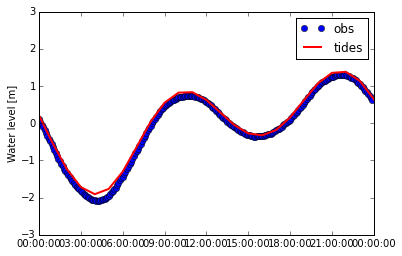

In [8]:
date = datetime.datetime(2015,11,28)
start_date = datetime.datetime.strftime(date,'%d-%b-%Y')
end_date = datetime.datetime.strftime(date,'%d-%b-%Y')

station_no = figures.SITES['Neah Bay']['stn_no']

obs = figures.get_NOAA_wlevels(station_no,start_date,end_date)
tide =figures.get_tides('Neah Bay')

plt.plot(obs.time, obs.wlev, 'o',label='obs')
plt.plot(tide.time, tide.pred_all,'r',lw=2,label='tides')

plt.legend(loc=0)

plt.ylabel('Water level [m]')
plt.axis([date, date +datetime.timedelta(days=1),-3,3,])

print(obs.time)

# Interpolate data to on the hour

[datetime.datetime(2015, 11, 28, 0, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 1, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 2, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 3, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 4, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 5, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 6, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 7, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 8, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 9, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 10, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 11, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 12, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 13, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 14, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 15, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 16, 0, tzinfo=tzutc()), datetime.datetime(2015, 11, 28, 17, 0, tzinfo=tzutc()), d

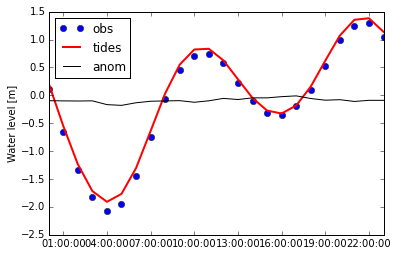

In [10]:
#create houly times
t1=date.replace(tzinfo=tz.tzutc())
t2 = t1 +datetime.timedelta(days=1)
hourlys = [t1 + datetime.timedelta(hours=hour) for hour in np.arange(0,(t2-t1).total_seconds()/3600)]

obs_interp = figures.interp_to_model_time(hourlys, obs.wlev, obs.time)
obs_interp=np.array(obs_interp)
tides_interp = figures.interp_to_model_time(hourlys, tide.pred_all, tide.time)
tides_interp=np.array(tides_interp)
anom=obs_interp-tides_interp

plt.plot(hourlys, obs_interp, 'o',label='obs')
plt.plot(hourlys, tides_interp, 'r', lw=2,label='tides')
plt.plot(hourlys, anom,'-k',label='anom')
plt.legend(loc=0)

plt.ylabel('Water level [m]')

print(hourlys)

# Save as a NetCDF

Follow Susan's SSH notebook for this. Make a new netcdf file for this day. I will save the anom at each point along the western boundary.

Get some preliminary data first: bathymetry, indices of the edges. 

In [12]:
startj = 384
endj = 471
lengthj = endj-startj
r = 1

fB = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')
lat = fB.variables['nav_lat'][:]
lon = fB.variables['nav_lon'][:]
fB.close()
print(lat.shape)

(898, 398)


A function for saving the netcdf file.

In [13]:
def prepare_netcdf(ssh_file, count, ssh,date):
    
    filename = date.strftime('ssh_y%Ym%md%d.nc')
    # dataset attributes
    nc_tools.init_dataset_attrs(
    ssh_file, 
    title='Juan de Fuca SSH hourly values', 
    notebook_name='SSH_NeahBay', 
    nc_filepath='/ocean/nsoontie/MEOPAR/sshNeahBay/obs/' + filename,
    comment='Neah Bay observed anomaly')

    
    #dimensions
    ssh_file.createDimension('xbT', lengthj*r)
    ssh_file.createDimension('yb', 1)
    ssh_file.createDimension('time_counter', None)
    # variables
    # time_counter
    time_counter = ssh_file.createVariable('time_counter', 'float32', ('time_counter'))
    time_counter.long_name = 'Time axis'
    time_counter.axis = 'T'
    time_counter.units = 'hour since 00:00:00 on {}'.format(date.strftime('%d/%m/%Y'))
    # nav_lat and nav_lon
    nav_lat = ssh_file.createVariable('nav_lat','float32',('yb','xbT'))
    nav_lat.long_name = 'Latitude'
    nav_lat.units = 'degrees_north'
    nav_lon = ssh_file.createVariable('nav_lon','float32',('yb','xbT'))
    nav_lon.long_name = 'Longitude'
    nav_lon.units = 'degrees_east'
    # ssh
    sossheig = ssh_file.createVariable('sossheig', 'float32', 
                               ('time_counter','yb','xbT'), zlib=True)
    sossheig.units = 'm'
    sossheig.long_name = 'Sea surface height'   
    sossheig.coordinates = 'nav_lon nav_lat time_counter'
    sossheig.grid = 'SalishSea2'
    # vobtcrtx, vobtcrty
    vobtcrtx = ssh_file.createVariable('vobtcrtx', 'float32',
                                   ('time_counter','yb','xbT'), zlib=True)
    vobtcrtx.units = 'm/s'
    vobtcrtx.long_name = 'Barotropic U Velocity- ZEROD'   
    vobtcrtx.grid = 'SalishSea2'
    vobtcrty = ssh_file.createVariable('vobtcrty', 'float32',
                                   ('time_counter','yb','xbT'), zlib=True)
    vobtcrty.units = 'm/s'
    vobtcrty.long_name = 'Barotropic V Velocity- ZEROD'   
    vobtcrty.grid = 'SalishSea2'
    # nbidta, ndjdta, ndrdta
    nbidta = ssh_file.createVariable('nbidta', 'int32' , ('yb','xbT'), zlib=True)
    nbidta.long_name = 'i grid position'
    nbidta.units = 1
    nbjdta = ssh_file.createVariable('nbjdta', 'int32' , ('yb','xbT'), zlib=True)
    nbjdta.long_name = 'j grid position'
    nbjdta.units = 1
    nbrdta = ssh_file.createVariable('nbrdta', 'int32' , ('yb','xbT'), zlib=True)
    nbrdta.long_name = 'position from boundary'
    nbrdta.units = 1
    
    for ir in range(0,r):
        nav_lat[0,ir*lengthj:(ir+1)*lengthj] = lat[startj:endj,ir]
        nav_lon[0,ir*lengthj:(ir+1)*lengthj] = lon[startj:endj,ir]
        nbidta[0,ir*lengthj:(ir+1)*lengthj] = ir
        nbjdta[0,ir*lengthj:(ir+1)*lengthj] = range(startj,endj)
        nbrdta[0,ir*lengthj:(ir+1)*lengthj] = ir
        
    for ib in range(0,lengthj*r):
        sossheig[0:count,0,ib] = ssh[0:count]
        time_counter[0:count] = range(1,count+1)
        vobtcrtx[0:count,0,ib] = 0*np.ones(count)
        vobtcrty[0:count,0,ib] = 0*np.ones(count)


Loop through the ssanomaly and time arrays to create the netcdf files.  Save them month by month.

This is really clunky for now. I need the netcdf files in UTC, but all of the data files are in local time. So I will just ignore/delete the first and last month's files since these are incomplete. There is definitely room for improvement with this part of the code.

In [14]:
#Create file
filename = date.strftime('ssh_y%Ym%md%d.nc')
count =24; 
ssh_file = NC.Dataset(filename, 'w', zlib=True)
prepare_netcdf(ssh_file,count,anom,date)
ssh_file.close()
    

file format: NETCDF4
Conventions: CF-1.6
title: Juan de Fuca SSH hourly values
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/I_ForcingFiles/OBC/SSH_NeahBay.ipynb
references: REQUIRED
history: [2015-11-30 16:01:42] Created netCDF4 zlib=True dataset.
comment: Neah Bay observed anomaly


# Check the NetCDF files

A quick check that the data is saved in the netcdf file as expected. 

<class 'netCDF4._netCDF4.Dimension'>: name = 'xbT', size = 87

<class 'netCDF4._netCDF4.Dimension'>: name = 'yb', size = 1

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 24

(24, 1, 87)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
-0.180557
-0.010159
(24, 1, 87)


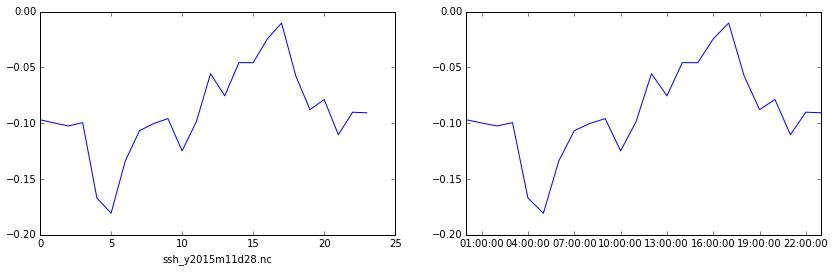

In [17]:


f=  NC.Dataset(filename,'r');

for dim in f.dimensions.values():
    print (dim)
    
ssh=f.variables['sossheig'];
us=f.variables['vobtcrtx'];
vs=f.variables['vobtcrty'];
print( us.shape)
print (us[1,0,:])
print (vs[:,0,:])
    
mn = ssh[:].min(); print (mn)
mx = ssh[:].max(); print (mx)

fig, ((ax_net,ax_data)) = plt.subplots(1, 2, figsize=(14,4))
ax_net.plot(ssh[:,0,0])
ax_net.set_xlabel(filename)

ax_data.plot(hourlys,anom)

print(ssh.shape)

This looks good so let's move the files out of my working directory and into the forcing directory. 

In [19]:
srcdir='.'
dstdir='/results/forcing/sshNeahBay/obs/'

import shutil

for basename in os.listdir(srcdir):
    if basename.endswith('.nc'):
        pathname = os.path.join(srcdir, basename)
        if os.path.isfile(pathname):
            shutil.copy2(pathname, dstdir)
